# Porto Seguro Data Challenge
---

## Definição do Problema

**Objetivo**: "Nessa competição você será desafiado a construir um modelo que prediz a probabilidade de aquisição de um produto."


Obs.: Segundo a descrição, a medida utilizada como critério de avaliação será a F1 e a medida Sensibilidade como critério para desempate

<p style="color:red">Se gostou não esqueça do voto! 🤘</p>

<div class="alert alert-warning"> 
<big><strong>⚠️ Atenção! <br></strong> </big>
    
<div style="color: rgb(0, 0, 0);">Este notebook pode sofrer alterações!</div>
</div>

# Carregar dependências
---

In [1]:
# Load packages
library(tidyverse)
library(tidymodels)
library(patchwork)
library(FactoMineR)
library(factoextra)

# Set theme
theme_set(theme_bw()) 

options(warn = -1)

fig <- function(width, heigth){
    # borrowed from https://www.kaggle.com/getting-started/105201
    options(repr.plot.width = width, repr.plot.height = heigth)
}
set.seed(42)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.7      ✔ rsample      0.1.0 
✔ dials        0.0.9      ✔ tune         0.1.5 
✔ infer        0.5.4      ✔ workflows    0.2.2 
✔ modeldata    0.1.0      ✔ workflowsets 0.0.2 
✔ parsnip      0.1.5      ✔ yardstick    0.0.8 
✔ recipes      0.1.16     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spe

In [2]:
train <- read_csv('../input/porto-seguro-data-challenge//train.csv')
test <-  read_csv('../input/porto-seguro-data-challenge//test.csv')
meta <- read_csv("../input/porto-seguro-data-challenge//metadata.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  `Variavel cod` = col_character(),
  `Variavel tipo` = col_character()
)




In [3]:
prep_data <- function(x, test=F){
    
   x <- x %>% mutate_all(~ifelse(.x == -999, NA_real_, .x))
    
    for(j in 1:nrow(meta)){

        if(str_detect(meta[j, 2], "^Qualitativo")){

            if(str_detect(meta[j, 2], "Qualitativo ordinal")){
                x[,j] <- factor(x %>% pull(j), ordered=T)
            }else if(str_detect(meta[j, 2], "Qualitativo nominal")){
                x[,j] <- as.factor(x %>% pull(j))
            }   
        }
    }
    if(test==F){
        x$y = as.factor(x$y)
    }
    
    return(x)
}

train <- prep_data(train)

# * Obs essa funcao nao trata novas classes para categoricas nos dados de teste!

# Análise Exploratória dos Dados
---

In [4]:
# Get data types
num_features <- train %>% select_if(is.numeric) %>% colnames()
cat_features <- train %>% select_if(is.factor) %>% select(-id) %>% colnames()

## Estrutura geral dos dados

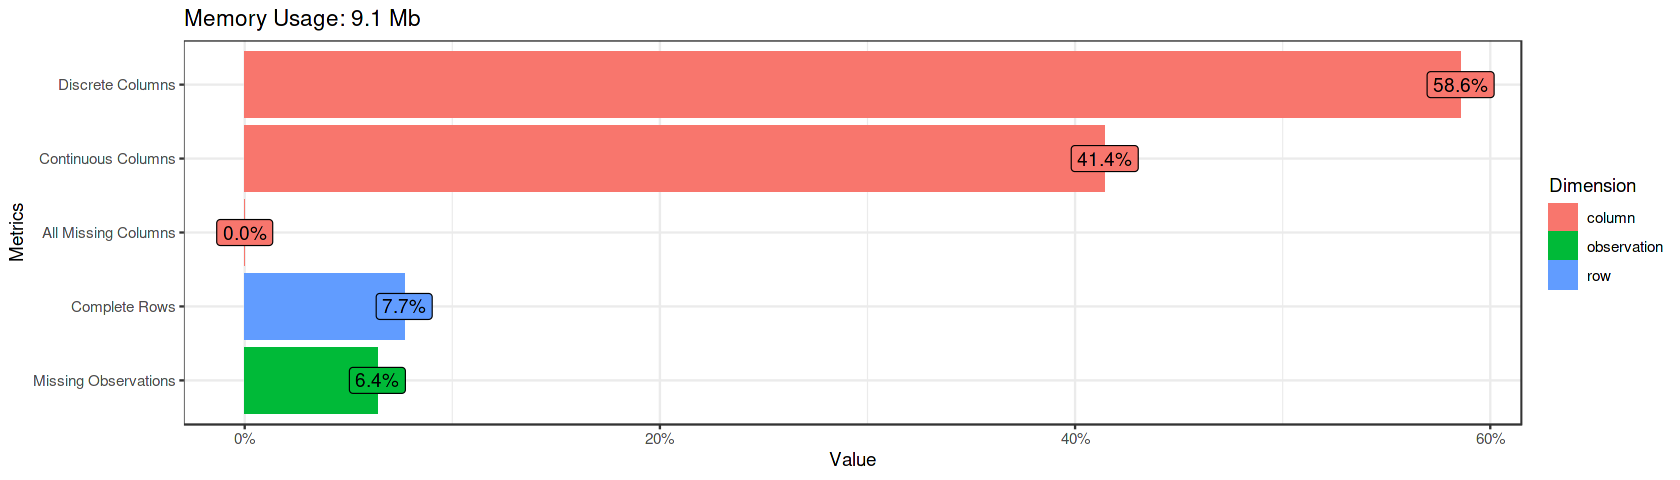

In [5]:
fig(14, 4)
DataExplorer::plot_intro(train, ggtheme = theme_bw())

<div class="alert alert-info"> 
<strong>📌  Interpretação:</strong> <br>

<div style="color: rgb(0, 0, 0);">Cerca de 6.4% dos dados são faltantes;</div>
<div style="color: rgb(0, 0, 0);">A maioria das features é categórica.</div>
    
</div>

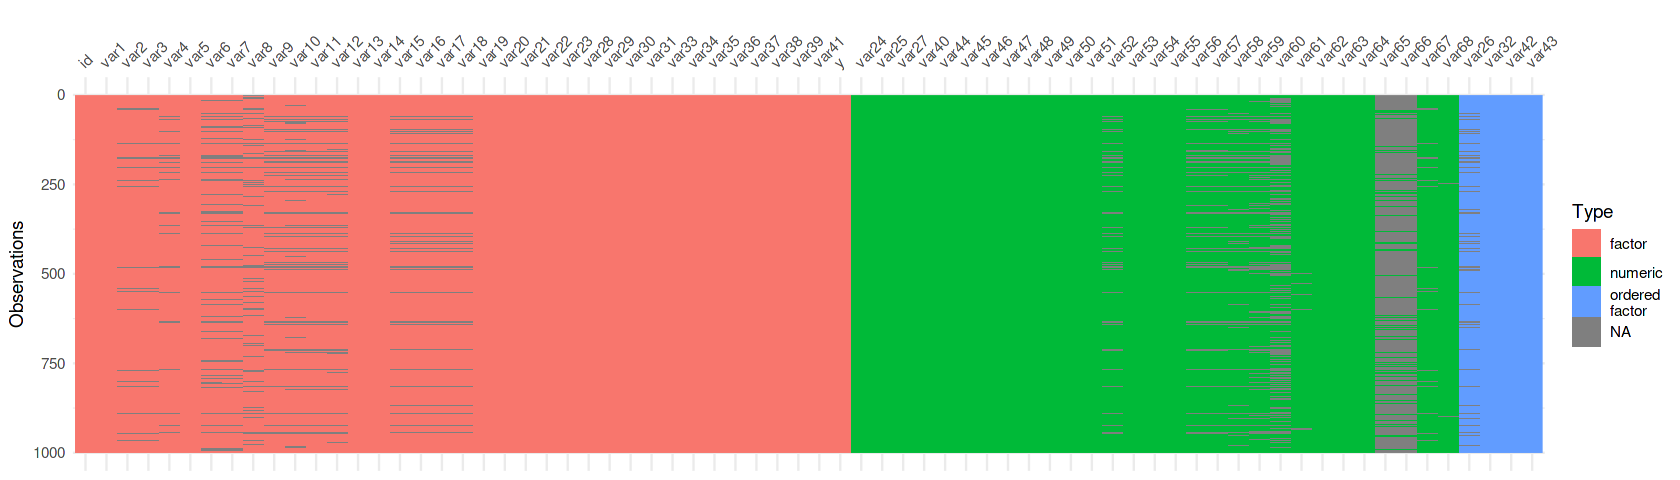

In [6]:
train %>% sample_n(1000) %>% visdat::vis_dat()

<div class="alert alert-warning"> 
<strong>💡 Insights!</strong> 
    
<div style="color: rgb(0, 0, 0);">Parece haver algum padrão nos dados faltantes</div>
</div>

In [7]:
paste0("O Dataset possui ", scales::comma(decimal.mark = ",", big.mark = ".", nrow(train)) , " linhas e ", ncol(train), " colunas")

[1] "O Dataset possui 14.123 linhas e 70 colunas"

In [8]:
# Tipo de cada feature
meta %>%
    count(`Variavel tipo`)

Variavel tipo,n
<chr>,<int>
Qualitativo nominal,36
Qualitativo ordinal,4
Quantitativo continua,12
Quantitativo discreto,18


## Features Categóricas

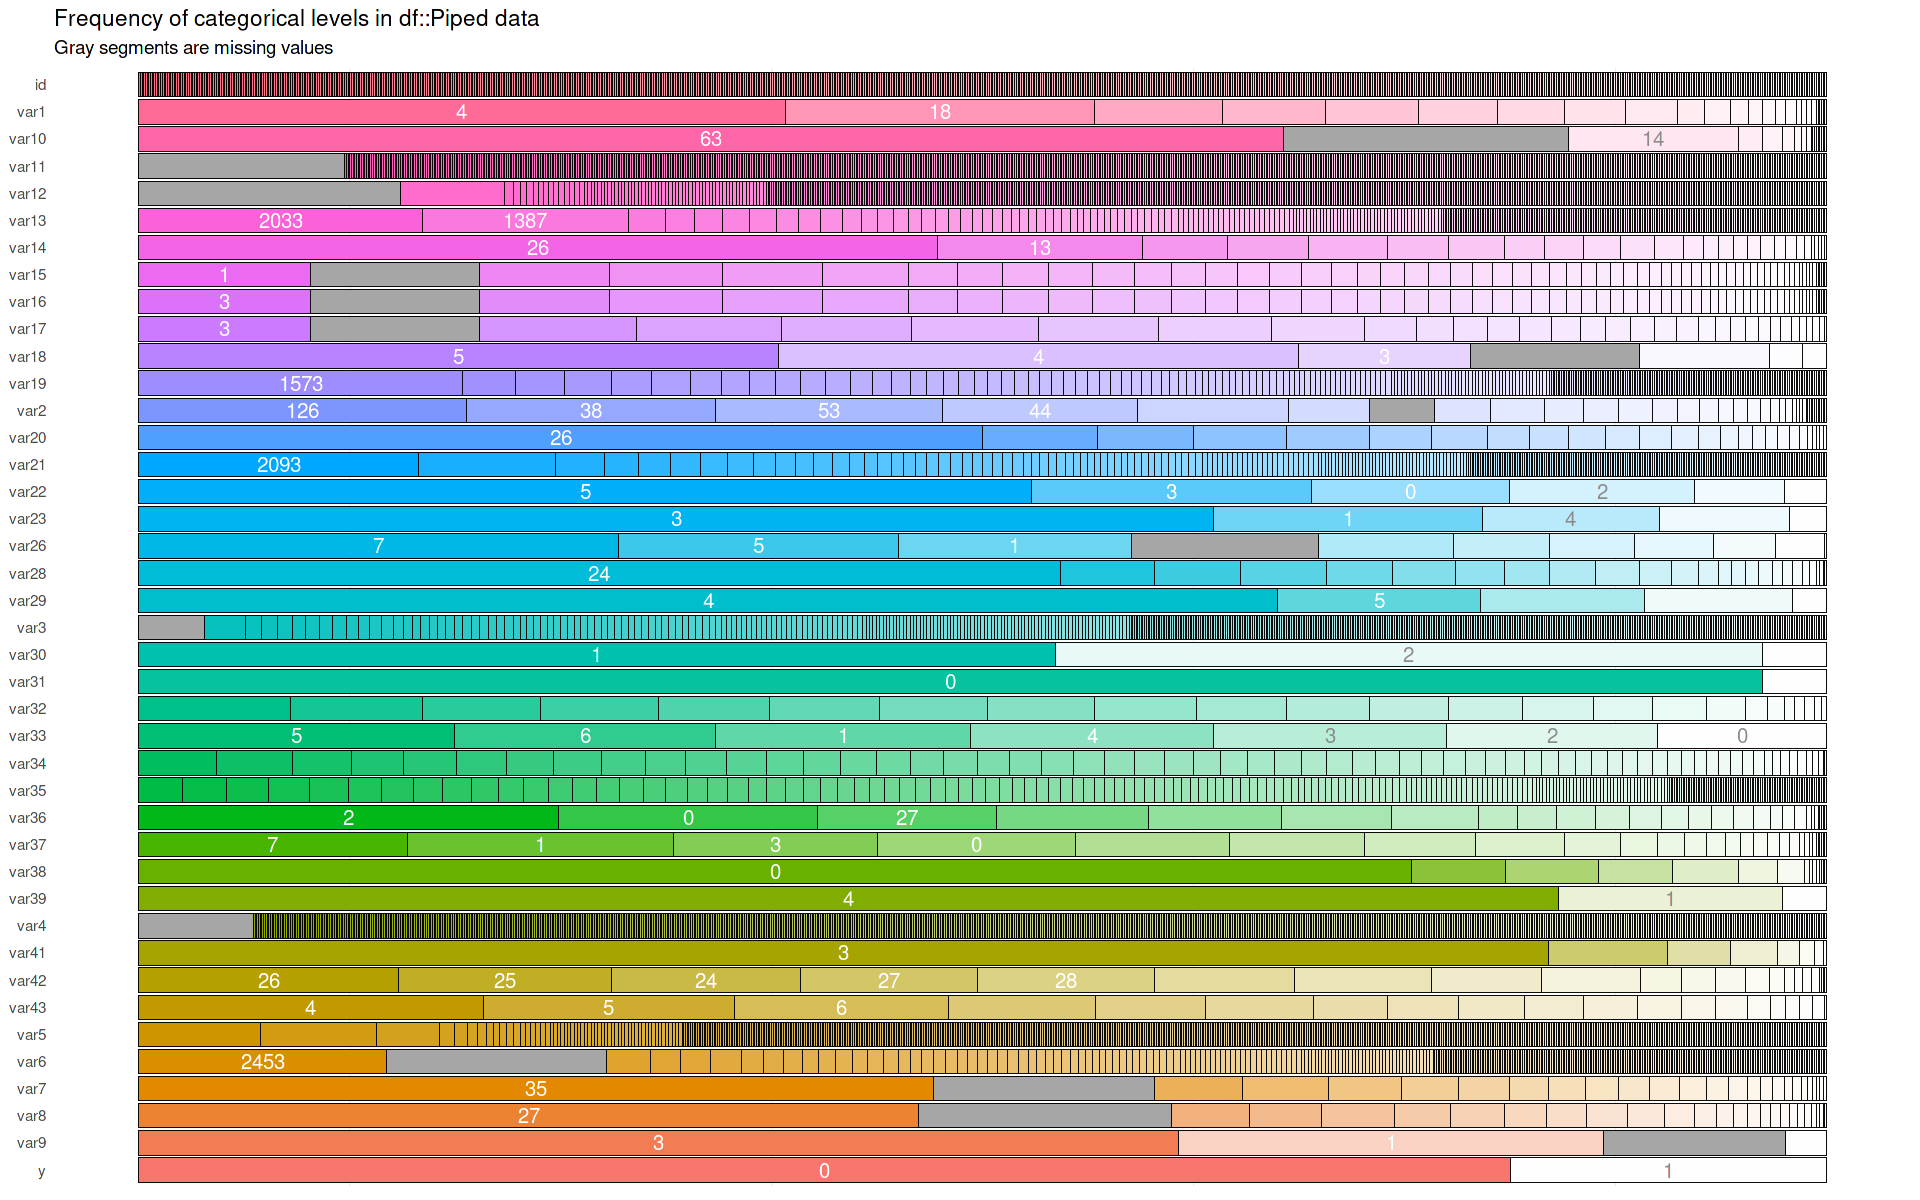

In [9]:
fig(16, 10)
train %>% 
  sample_n(1000) %>% 
  inspectdf::inspect_cat() %>% 
  inspectdf::show_plot()

<div class="alert alert-info"> 
<strong>📌  Interpretação:<br></strong> 

<pdiv style="color: rgb(0, 0, 0);">Algumas features categóricas apresentam muitas classes (centenas ou milhares)!</div>

</div>

Número de classes diferentes em cada feature:

In [10]:
train %>% 
  select(all_of(cat_features)) %>% 
  map_dbl(~length(unique(.x))) %>%
  sort()

var31     y var30  var9 var23 var22 var29 var39 var18 var33 var41 var26 var43 
    2     2     3     4     5     6     6     6     7     7    10    11    20 
var32 var14 var20 var28  var1  var8 var38 var42  var7 var17 var36 var37 var10 
   24    28    28    28    29    29    29    31    33    33    33    47    61 
var34 var15 var16  var2 var35 var19 var13 var21  var6  var3 var12  var5 var11 
   69    77    77    85   567  1201  1499  1534  1779  2443  5270  6296 12384 
 var4 
13094

## Features Numéricas

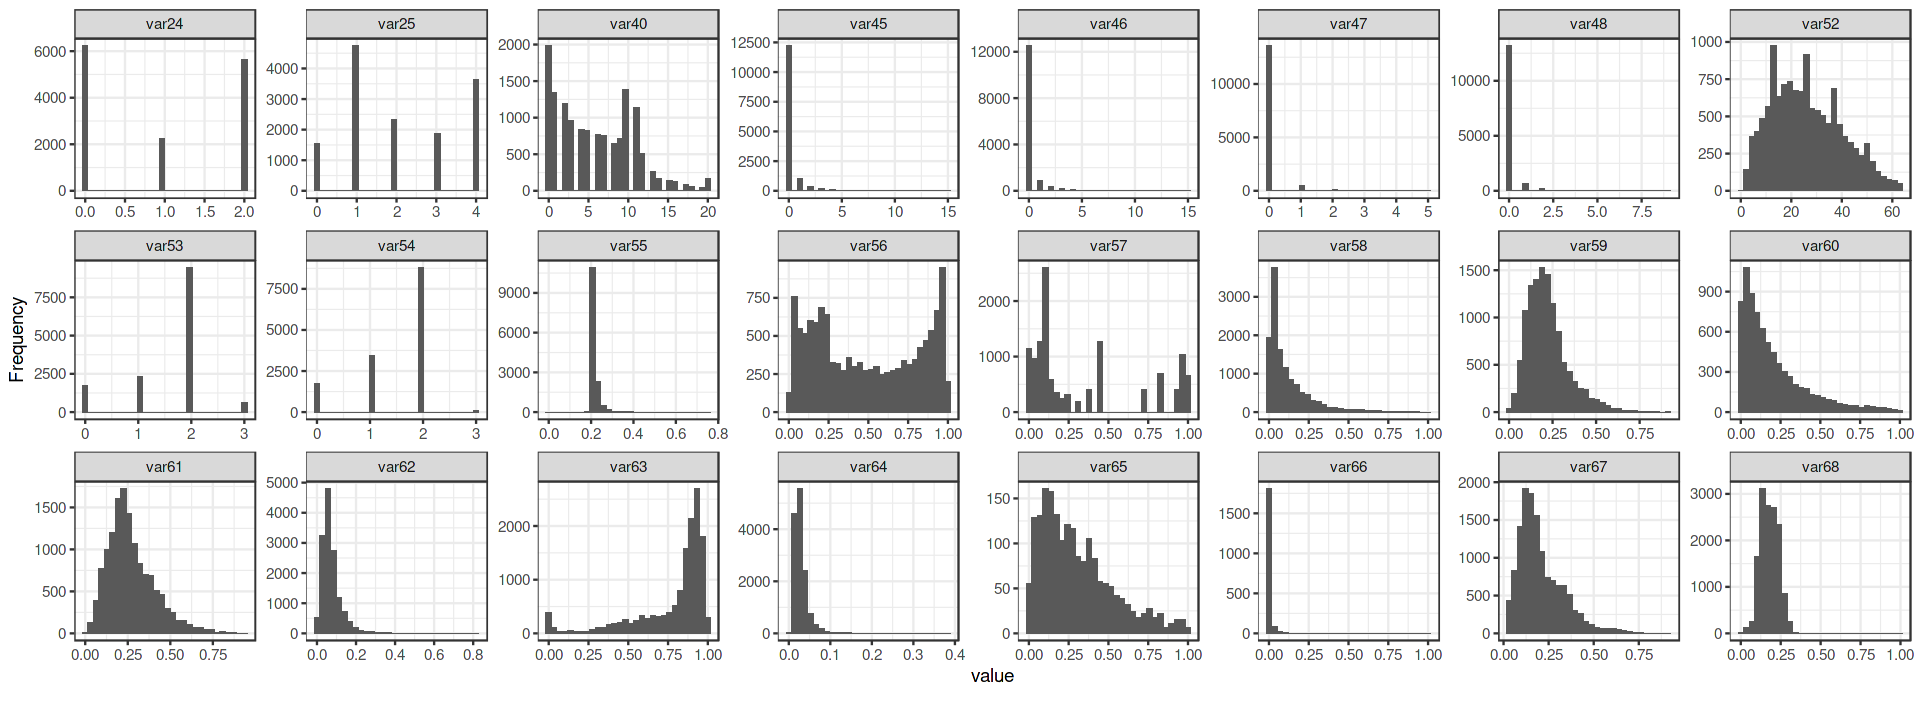

In [11]:
fig(16, 6)
train %>% 
  dplyr::select(-id) %>% 
  DataExplorer::plot_histogram(nrow = 3, ncol = 8, ggtheme = theme_bw())

<div class="alert alert-info"> 
<strong>📌  Interpretação:<br></strong> 

<div style="color: rgb(0, 0, 0);">Maioria das features numéricas é discreta;</div>
<div style="color: rgb(0, 0, 0);">As features contínuas possuem distribuições assimétricas</div>

</div>

Em relação a target:

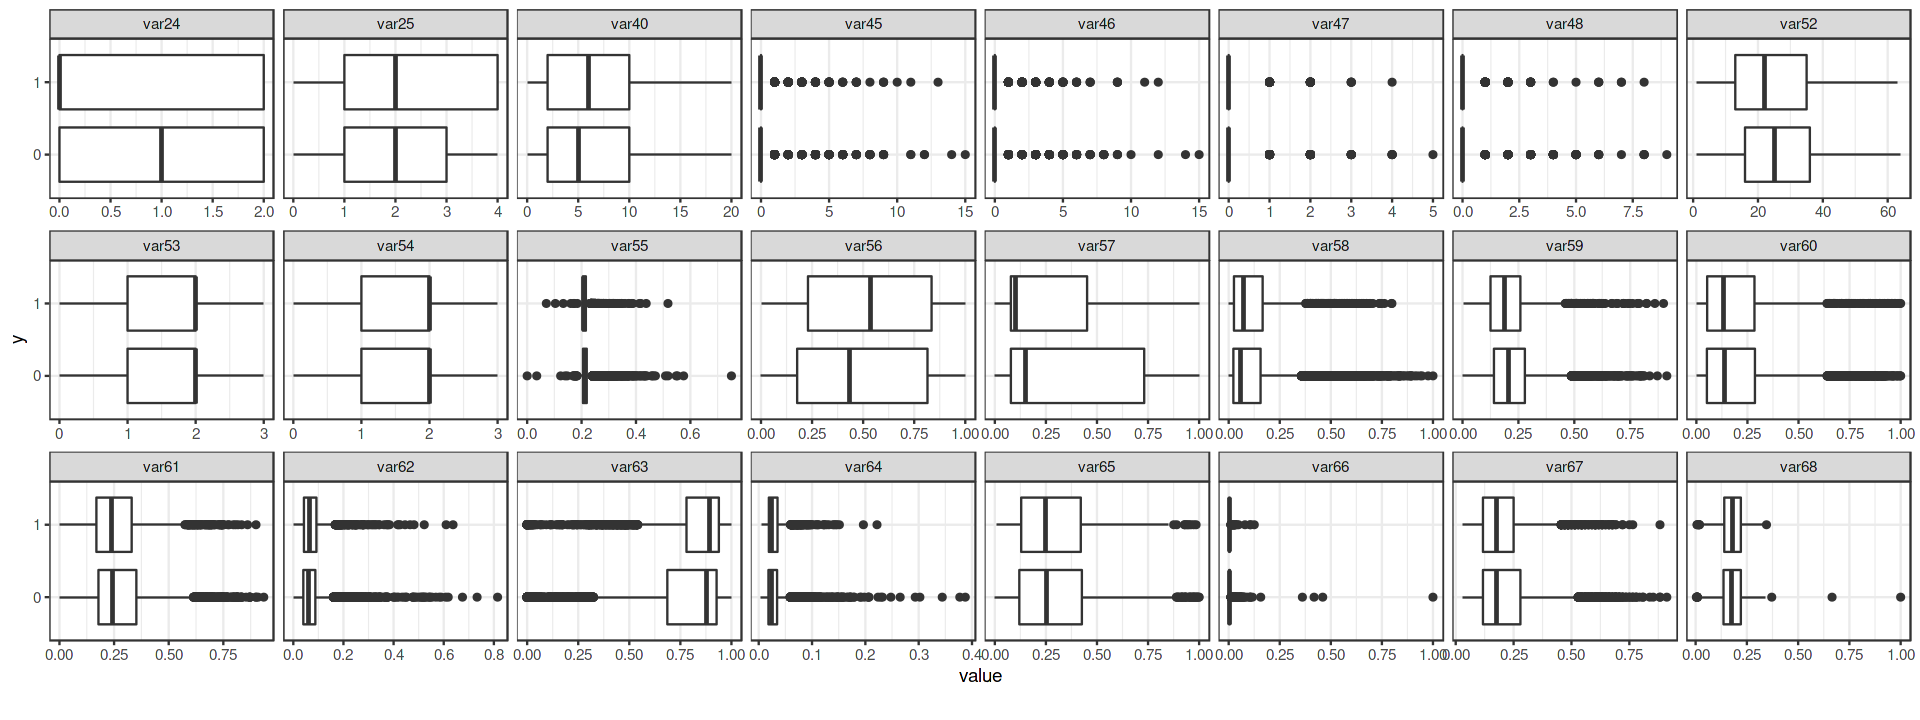

In [12]:
fig(16, 6)

train %>% 
  select(all_of(num_features), y) %>% 
  filter(!is.na(y)) %>% 
  DataExplorer::plot_boxplot(nrow = 3, ncol = 8, by = 'y',
                             ggtheme = theme_bw())

# Target

Distribuição da target:

In [13]:
n_target <- train %>% 
  count(y) %>% 
  mutate(prop = n/sum(n, na.rm = T)) %>% 
  arrange(desc(y))

n_target

y,n,prop
<fct>,<int>,<dbl>
1,2850,0.2017985
0,11273,0.7982015


In [14]:
p1 <- n_target %>% 
  ggplot(aes(x=rev(y), y=n, fill=y))+
  geom_bar(stat = "identity")+
  scale_fill_brewer(palette="Set1", name="TARGET")+
  theme(legend.position = "bottom")+
  labs(y="Número de instâncias", x = "")

p2 <- n_target %>% 
  na.omit() %>% 
  arrange(desc(y)) %>%
  mutate(prop = n / sum(n)) %>%
  mutate(ypos = cumsum(prop)- 0.5*prop )%>% 
  ggplot(aes(x="", y=prop, fill=y)) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) +
  theme_void() + 
  theme(legend.position="none") +
  geom_text(aes(y = ypos,
                label = paste(scales::comma(n, big.mark = ".", decimal.mark=","),
                              scales::comma(n/sum(n), big.mark = ".", decimal.mark=",", 
                                            suffix = "%" ),sep = "\n")
                
  ), 
  color = "white", size=6) +
  scale_fill_brewer(palette="Set1")

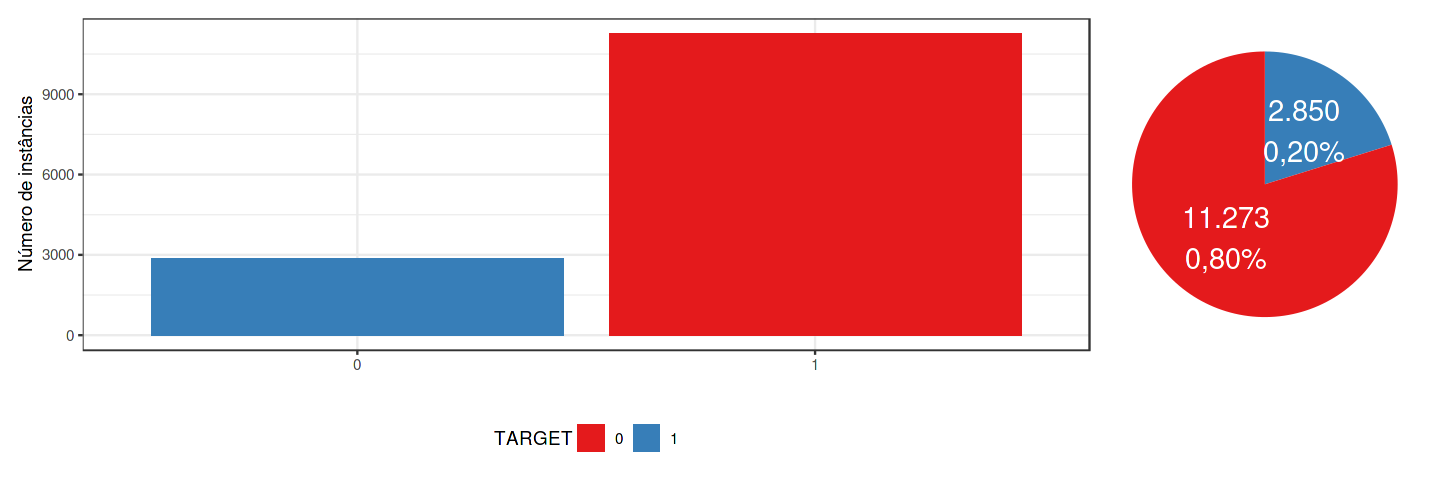

In [15]:
fig(12, 4)
p1 + p2 

<div class="alert alert-danger"> 
<strong>⚠️ Atenção!</strong> 

<div style="color: rgb(0, 0, 0);">A distribuição da target é levemente desbalanceada!</div>

# Análise Multivariada

Correlações e dendograma:

In [16]:
p <- train %>% 
  select(all_of(num_features)) %>% 
  cor(use = "complete.obs") %>% 
  round(5) %>%
  heatmaply::heatmaply(k_row = 2, k_col = 3)

htmlwidgets::saveWidget(p, "p.html")
IRdisplay::display_html('<iframe src="p.html" width=800, height=600></iframe> ') 

<div class="alert alert-info"> 
<strong>📌  Interpretação:</strong> 

<div style="color: rgb(0, 0, 0);">Não parece haver problema de multicolineariedade nos dados;</div>
<div style="color: rgb(0, 0, 0);">Não parece haver clusters bem definidos nos dados</div>
</div>

In [17]:
res.pca <- train %>% 
    select(all_of(num_features)) %>%
    PCA(graph = FALSE, scale.unit = T)

fig(14, 5)
p1 <- fviz_eig(res.pca, addlabels = TRUE)

p2 <- fviz_pca_biplot(res.pca, repel = TRUE,label = T,
                col.var = "#2E9FDF", # Variables color
                col.ind = "#696969"  # Individuals color
                )

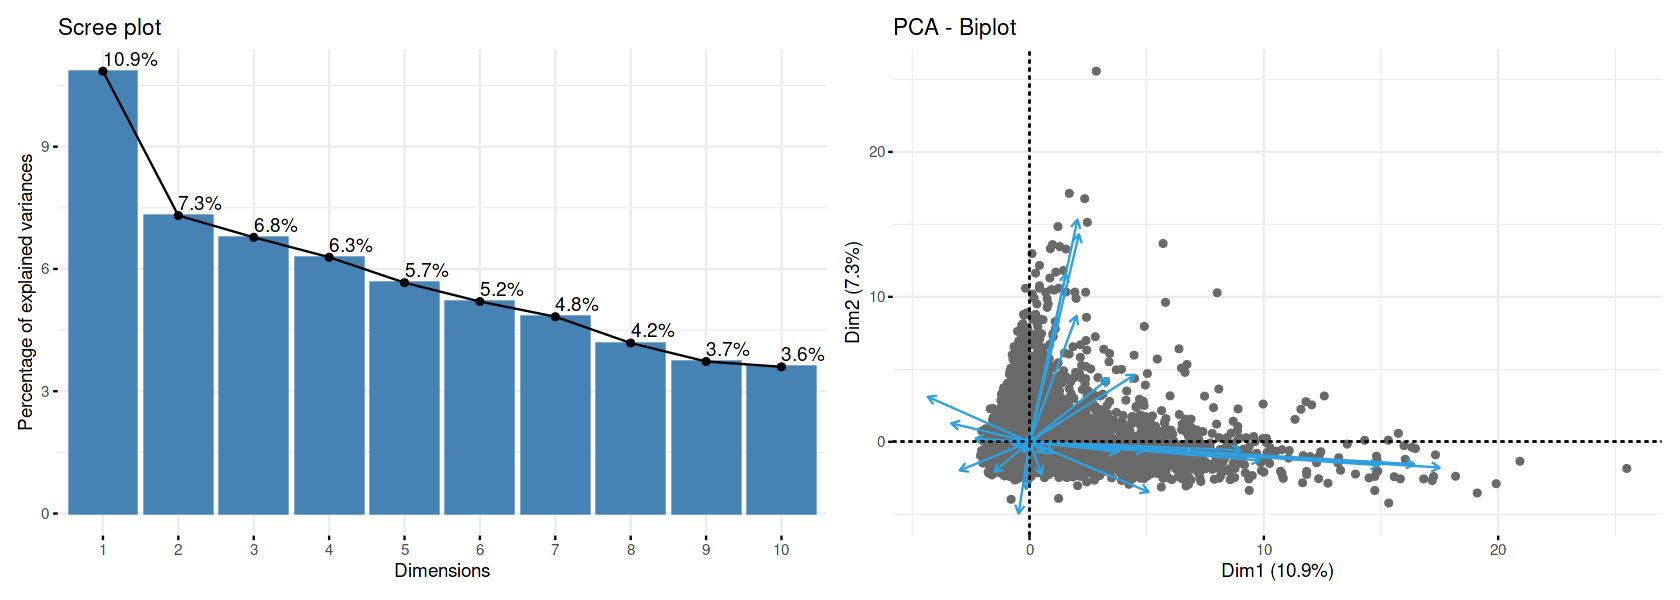

In [18]:
p1 + p2

<div class="alert alert-warning"> 
<strong>💡 Insights!</strong>
    
<div style="color: rgb(0, 0, 0);">Talvez a PCA não seja uma boa estratégia para diminuir a dimensionalidade dos dados;</div>
<div style="color: rgb(0, 0, 0);">Talvez existam alguns outliers neste conjunto de dados.</div>
</div>


# Modelo Nulo
---

Apenas para fins ilustrativos e efeitos de comparação, um modelo nulo será ajustado. (Este modelo nulo irá prever sempre a classe majoritária)

In [19]:
# Cross validation
folds <- vfold_cv(train, v = 5, strata = y)

# Important metrics
metrics <- metric_set(f_meas, mn_log_loss, accuracy, sensitivity, specificity)

In [20]:
null_spec <- null_model(mode = "classification") %>% 
  set_engine("parsnip")

base_rec <- recipe(y ~ ., data = train) 

null_wf <-
  workflow() %>%
  add_recipe(base_rec) %>%
  add_model(null_spec)

null_rs <-
  fit_resamples(
    object = null_wf,
    resamples = folds,
    metrics = metrics,
    control = control_resamples(save_pred = TRUE)
  ) 

collect_metrics(null_rs)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7982015,5,1.750118e-05,Preprocessor1_Model1
f_meas,binary,0.8877776,5,1.082490e-05,Preprocessor1_Model1
mn_log_loss,binary,0.5028856,5,2.406616e-05,Preprocessor1_Model1
sens,binary,1.0000000,5,0.000000e+00,Preprocessor1_Model1
spec,binary,0.0000000,5,0.000000e+00,Preprocessor1_Model1


Resultados de forma visual:

In [21]:
p1 <- 
    collect_predictions(null_rs) %>%
    select(.pred_class, y) %>%
    table() %>% 
    conf_mat() %>% 
    autoplot(type = "heatmap")+
    labs(title = "Matriz de confusão")
p2 <- 
    collect_predictions(null_rs) %>%
    ggplot() +
    geom_density(aes(x = .pred_1, fill = y), 
                 alpha = 0.5)+
    labs(title = "Distribuições de probabilidade previstas",
         subtitle = "por classe")+ 
    scale_x_continuous(limits = 0:1)+
    scale_fill_brewer(palette="Set1")

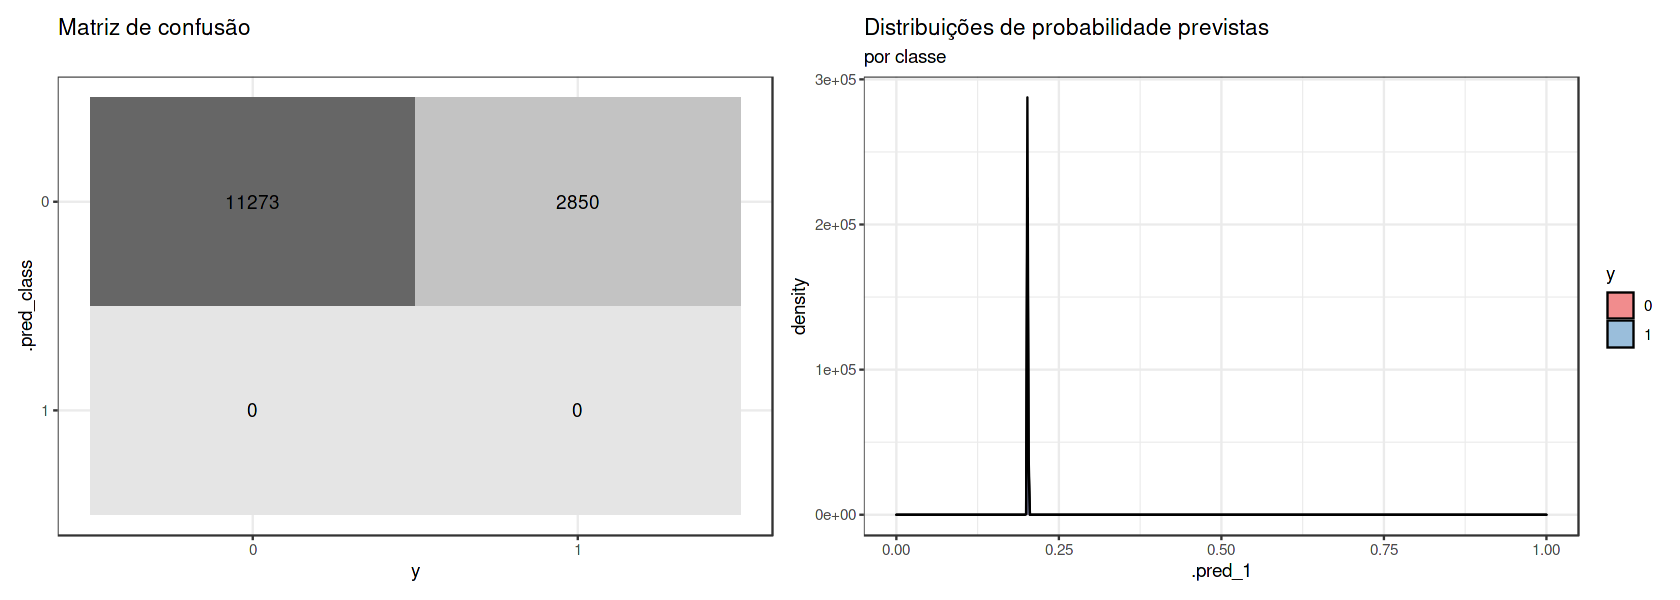

In [22]:
p1 | p2

# Conclusão
---

O objetivo deste notebook foi apenas trazer alguma primeira impressão sobre os dados, contextualizando e descobrindo aonde estamos pisando. Diversos dos pontos que foram levantados necessitam de alguma análise mais aprofundada. 

Boa sorte a todos!